DL_MRI_reconstruction_baselines_2

In [21]:
%matplotlib inline

import os
import h5py
import numpy as np
from matplotlib import pyplot as plt
import bart

import fastmri
from fastmri.data import transforms as T

In [2]:
download_path = '/usr/local/micapollo01/MIC/DATA/SHARED/NYU_FastMRI/Preprocessed'
dicom_path = os.path.join(download_path,'fastMRI_brain_DICOM')
train_path = os.path.join(download_path,'multicoil_train')
validation_path = os.path.join(download_path,'multicoil_val')
test_path = os.path.join(download_path,'multicoil_test')
fully_sampled_test_path = os.path.join(download_path,'multicoil_test_full')


In [3]:
file_name = 'file_brain_AXFLAIR_210_6001949.h5'
hf = h5py.File(os.path.join(fully_sampled_test_path, file_name),'r')


In [4]:
volume_kspace = hf['kspace'][()]
slice_kspace = volume_kspace[3]
print(slice_kspace.dtype)
print(slice_kspace.shape)


complex64
(16, 640, 320)


In [5]:
GT = hf['reconstruction_rss']
GT = np.array(GT)
vmin = np.percentile(GT[3], 1)
vmax = np.percentile(GT[3], 99)


In [6]:
! bart

BART. Available commands are:
avg         bench       bitmask     cabs        caldir      calmat      
carg        casorati    cc          ccapply     cdf97       circshift   
conj        conv        copy        cpyphs      creal       crop        
delta       ecalib      ecaltwo     estdelay    estdims     estshift    
estvar      extract     fakeksp     fft         fftmod      fftrot      
fftshift    filter      flatten     flip        fmac        homodyne    
index       invert      itsense     join        looklocker  lrmatrix    
mandelbrot  mip         moba        nlinv       noise       normalize   
nrmse       nufft       ones        pattern     phantom     pics        
pocsense    poisson     poly        repmat      reshape     resize      
rof         rss         sake        saxpy       scale       sdot        
show        slice       spow        sqpics      squeeze     std         
svd         tgv         threshold   toimg       traj        transpose   
twixread    var      

In [7]:
! bart ecalib -h

Usage: ecalib [-t f] [-c f] [-k ...] [-r ...] [-m d] [-S] [-W] [-I] [-1] [-P] [-v f] [-a] [-d d] <kspace> <sensitivites> [<ev-maps>]

Estimate coil sensitivities using ESPIRiT calibration.
Optionally outputs the eigenvalue maps.

-t threshold      	This determined the size of the null-space.
-c crop_value      	Crop the sensitivities if the eigenvalue is smaller than {crop_value}.
-k ksize      	kernel size
-r cal_size      	Limits the size of the calibration region.
-m maps      	Number of maps to compute.
-S		create maps with smooth transitions (Soft-SENSE).
-W		soft-weighting of the singular vectors.
-I		intensity correction
-1		perform only first part of the calibration
-P		Do not rotate the phase with respect to the first principal component
-v variance      	Variance of noise in data.
-a		Automatically pick thresholds.
-d level      	Debug level
-h		help


In [8]:
import scipy.io as sio

mat_file = sio.loadmat('/usr/local/micapollo01/MIC/DATA/STUDENTS/mvhave7/Results/GitLab/master_thesis/fastMRI/sampling_profiles_CS.mat')
mat_file.keys()


dict_keys(['__header__', '__version__', '__globals__', 'm256_CS1_mask', 'm256_CS2_mask', 'm256_CS4_mask', 'm256_CS6_mask', 'm256_CS8_mask', 'm256_full_mask', 'm320_CS1_mask', 'm320_CS2_mask', 'm320_CS4_mask', 'm320_CS6_mask', 'm320_CS8_mask', 'm320_full_mask'])

In [9]:
# First, we estimate our sensitivity maps as if we have undersampled data with an ACS region

from fastmri.data.subsample import RandomMaskFunc

def estimate_sensitivity_maps(kspace):
    ''' 
    Args:
        kspace (numpy.array): slice kspace of shape (num_coils, rows, cols)
    Returns:
        S (numpy.array): Estimated sensitivity maps given by ESPIRiT of shape (num_coils, rows, cols)
    '''
    # Move coil axis to the back as expected by BART
    kspace_perm = np.moveaxis(kspace, 0, 2)
    # Add extra dimension, because the ESPIRiT method expects a 4D input array where the third dimension represents the batch size.
    kspace_perm = np.expand_dims(kspace_perm, axis=2)
    # Estimate sensitivity maps with ESPIRiT method
    S = bart.bart(1, "ecalib -d0 -m1", kspace_perm)
    # Undo the previous operations to get the original data structure back
    S = np.moveaxis(S.squeeze(), 2, 0)
    return S

def apply_mask(slice_kspace, mask_func):
    ''' 
    Args:
        slice_kspace (numpy.array)
        mask_func (class)
    Returns:
        masked_kspace (numpy.array)
        mask (torch.tensor)
    '''
    slice_kspace_T = T.to_tensor(slice_kspace)
    masked_kspace_T, mask = T.apply_mask(slice_kspace_T, mask_func)   # Apply the mask to k-space
    masked_kspace = T.tensor_to_complex_np(masked_kspace_T)
    return masked_kspace, mask

mask_func = RandomMaskFunc(center_fractions=[0.08], accelerations=[2])
masked_kspace, mask = apply_mask(slice_kspace, mask_func)


In [10]:
S = estimate_sensitivity_maps(masked_kspace)


In [11]:
# Now, we can start looking at CS undersampling as used in the real world

def generate_array(shape, R, mat_file, tensor_out):
    if R ==2:
        array = mat_file['m320_CS2_mask'].squeeze()
    elif R == 4:
        array = mat_file['m320_CS4_mask'].squeeze()
    elif R == 8:
        array = mat_file['m320_CS8_mask'].squeeze()
    else:
        raise ValueError('Unrecognized acceleration factor specified. Must be 4 or 8.')
    # Calculate padding needed to reach the desired length
    desired_length = shape[-1]
    padding_needed = desired_length - len(array)
    if padding_needed > 0:
        # Calculate padding width for symmetric padding
        padding_width = (padding_needed // 2, padding_needed - padding_needed // 2)
        # Pad the array symmetrically
        array = np.pad(array, padding_width, mode='symmetric')
    elif padding_needed < 0:
        # Calculate trimming indices for symmetric trimming
        trim_start = -padding_needed // 2
        trim_end = len(array) + padding_needed // 2
        # Trim the array symmetrically
        array = array[trim_start:trim_end]
    # Make array compatible with fastmri mask function class
    for i in range(len(shape)-1):
        array = np.expand_dims(array, 0)
    if tensor_out:
        array = T.to_tensor(array)
    return array


In [12]:
# CS type mask
mask = generate_array(slice_kspace.shape, 2, mat_file, tensor_out=False)
masked_kspace = slice_kspace * mask + 0.0


In [13]:
! bart pics -h


Usage: pics [-l ...] [-r f] [-R ...] [-c] [-s f] [-i d] [-t <string>] [-n] [-N] [-g] [-G d] [-p <string>] [-I ...] [-b d] [-e] [-T <string>] [-W <string>] [-d d] [-O d] [-o f] [-u f] [-C d] [-q f] [-f f] [-m ...] [-w f] [-S] [-L d] [-K] [-B <string>] [-P f] [-a ...] [-M] [-U] <kspace> <sensitivities> <output>

Parallel-imaging compressed-sensing reconstruction.

-l1/-l2		toggle l1-wavelet or l2 regularization.
-r lambda      	regularization parameter
-R <T>:A:B:C	generalized regularization options (-Rh for help)
-c		real-value constraint
-s step      	iteration stepsize
-i iter      	max. number of iterations
-t file      	k-space trajectory
-n		disable random wavelet cycle spinning
-N		do fully overlapping LLR blocks
-g		use GPU
-G gpun      	use GPU device gpun
-p file      	pattern or weights
-I		select IST
-b blk      	Lowrank block size
-e		Scale stepsize based on max. eigenvalue
-T file      	(truth file)
-W <img>      	Warm start with <img>
-d level      	Debug level
-O rwiter  

In [14]:
! bart pics -Rh


Generalized regularization options (experimental)

-R <T>:A:B:C	<T> is regularization type (single letter),
		A is transform flags, B is joint threshold flags,
		and C is regularization value. Specify any number
		of regularization terms.

-R Q:C    	l2-norm in image domain
-R I:B:C  	l1-norm in image domain
-R W:A:B:C	l1-wavelet
-R N:A:B:C	Normalized Iterative Hard Thresholding (NIHT), image domain
		C is an integer percentage, i.e. from 0-100
-R H:A:B:C	NIHT, wavelet domain
-R F:A:B:C	l1-Fourier
-R T:A:B:C	total variation
-R T:7:0:.01	3D isotropic total variation with 0.01 regularization.
-R L:7:7:.02	Locally low rank with spatial decimation and 0.02 regularization.
-R M:7:7:.03	Multi-scale low rank with spatial decimation and 0.03 regularization.


In [15]:
def CS(kspace, S, lamda=0.005, num_iter=50):
    ''' 
    Performs CS reconstruction
    https://mrirecon.github.io/bart/

    Args:
        kspace (numpy.array): Slice kspace of shape (num_coils, rows, cols)
        S (numpy.array): Estimated sensitivity maps given by ESPIRiT of shape (num_coils, rows, cols)
        lamda: Value of the hyperparameter / regularizer of the l1 norm term
        num_iter: The amount of iterations the algorithm can run
    Returns:
        reconstruction (numpy.array): Estimated CS reconstruction of shape (rows, cols))
    '''
    # Move coil axis to the back as expected by BART
    kspace_perm = np.moveaxis(kspace, 0, 2)
    S_perm = np.moveaxis(S, 0, 2)
    # Add extra dimension, because BART expects a 4D input array where the third dimension represents the batch size.
    kspace_perm = np.expand_dims(kspace_perm, axis=2)
    S_perm = np.expand_dims(S_perm, axis=2)
    # Perform CS reconstruction
    reconstruction = bart.bart(1, 'pics -S -l1 -r {} -i {}'.format(lamda, num_iter), kspace_perm, S_perm)
    return reconstruction


In [16]:
reconstruction = CS(masked_kspace, S)


In [17]:
print(reconstruction.shape)
print(reconstruction.dtype)


(640, 320)
complex64


In [18]:
def comp_img(img,crop_size):
    s = img.shape
    start_height = s[0]//2 - (crop_size[0]//2)
    start_width = s[1]//2 - (crop_size[1]//2)
    return img[start_height:(start_height+crop_size[0]),start_width:(start_width+crop_size[1])]

dim1 = GT.shape[1]
dim2 = GT.shape[2]
reconstruction = comp_img(reconstruction,(dim1,dim2))


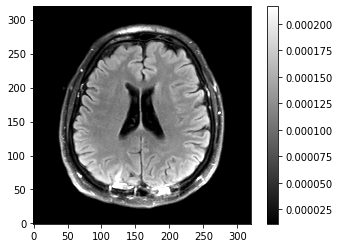

In [19]:
# R = 2
plt.imshow(np.abs(reconstruction), cmap='gray', origin='lower', vmin=vmin, vmax=vmax)
plt.colorbar()


Let's compare this to the normal RSS reconstruction

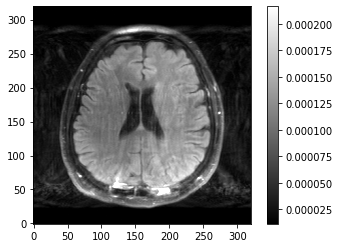

In [20]:
# R = 2
rss_image = fastmri.ifft2c(T.to_tensor(masked_kspace))
rss_image = fastmri.complex_abs(rss_image)
rss_image = fastmri.rss(rss_image, dim=0)
rss_image = comp_img(rss_image.numpy(),(dim1,dim2))
plt.imshow(np.abs(rss_image), cmap='gray', origin='lower', vmin=vmin, vmax=vmax)
plt.colorbar()
